<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [3]:
# Check for GPU
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [4]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42

2.7.1+cu126


## 1. What are 3 areas in industry where computer vision is currently being used?

In [5]:
# Transportation, healthcare, agriculture

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

In [6]:
# Overfitting is when the model does too well on the training set and poorly on the test set.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

In [7]:
# 1. Increasing training data: when models train on more data, they can generalize more
# 2. Regularization: attempts to remove the factors which do not contribute much to the prediction
# 3. Simplifying the model: overly complex model can make it so that your model might actually capture noise data

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

In [8]:
# Done

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [9]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root="data",
          train=True,
          download=True,
          transform=ToTensor(),
          target_transform=None)

test_data = datasets.MNIST(root="data",
                           train=False,
                           download=True,
                           transform=ToTensor(),
                           target_transform=None)

print(f"Train data samples: {len(train_data)}, Test data samples: {len(test_data)}")

class_names = train_data.classes

Train data samples: 60000, Test data samples: 10000


## 6. Visualize at least 5 different samples of the MNIST training dataset.

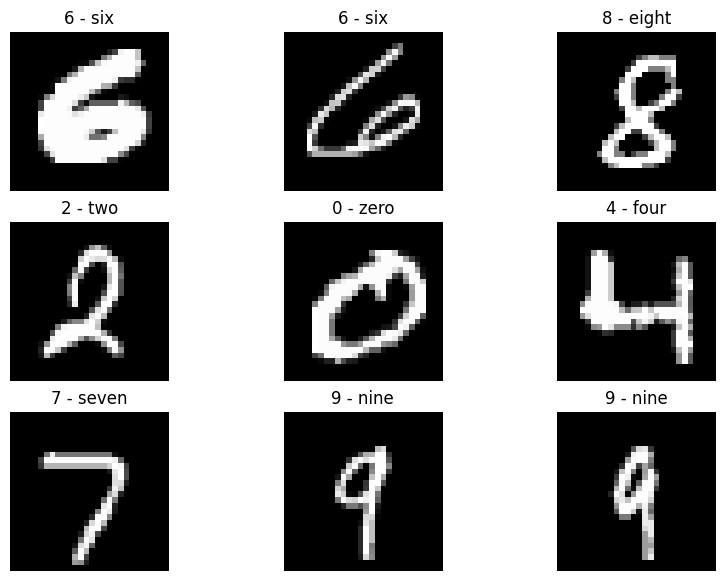

In [10]:
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

fig = plt.figure(figsize=(10,7))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

sample_data = train_dataloader.dataset.data[0]
sample_label = train_dataloader.dataset.targets[0]

print(f"Shape of sample data: {sample_data.shape}")
print(f"Sample label: {label}")

Shape of sample data: torch.Size([28, 28])
Sample label: 9


## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [12]:
from torch import nn

class MNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )        

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,  # [1, 10, 7, 7] is the size coming from conv_block_2, so we multiply the flattened layer by 7 * 7
                      out_features=output_shape)         # In context, the flattened layer is shaped 1x490
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [13]:
from torchmetrics import Accuracy


model = MNISTModel(input_shape=1,
                   hidden_units=10,
                   output_shape=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names))

In [14]:
# Checking size of flattened layer
dummy_input = torch.randn(size=(1, 1, 28, 28))  # (1, 1, 28, 28) is the size of a feature data in MNIST dataset.
output_logit = model(dummy_input)

# Checking logits
output_pred = torch.softmax(output_logit, dim=1).argmax(dim=1)
output_pred

tensor([4])

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [15]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

start_time = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n-------")

    batch_loss = 0
    batch_accuracy = 0
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        model.train()

        y_logits = model(X_train)

        loss = criterion(y_logits, y_train)
        batch_loss += loss

        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        batch_accuracy += accuracy_fn(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X_train)} / {BATCH_SIZE * len(train_dataloader)} samples")
    
    train_loss = batch_loss / len(train_dataloader)
    train_accuracy = batch_accuracy / len(train_dataloader)

    # Test set
    model.eval()

    with torch.inference_mode():
        test_accuracy = 0
        test_loss = 0

        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_logits = model(X_test)

            loss = criterion(test_logits, y_test)
            test_loss += loss

            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_accuracy += accuracy_fn(test_pred, y_test)

        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f} | Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

end_time = timer()

print(f"Total training time on {device}: {end_time - start_time}")

/home/shiba/Desktop/PyTorch for Deep Learning in 2023 Zero to Mastery/00. Repository/PyTorch-For-Deep-Learning-Bootcamp/.env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 20%|██        | 1/5 [00:14<00:57, 14.27s/it]

Train loss: 0.3135, Train accuracy: 0.8947 | Test loss: 0.0931, Test accuracy: 0.9721
Epoch: 1 
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 40%|████      | 2/5 [00:27<00:41, 13.91s/it]

Train loss: 0.0801, Train accuracy: 0.9754 | Test loss: 0.0662, Test accuracy: 0.9788
Epoch: 2 
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 60%|██████    | 3/5 [00:41<00:27, 13.86s/it]

Train loss: 0.0621, Train accuracy: 0.9809 | Test loss: 0.0515, Test accuracy: 0.9833
Epoch: 3 
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 80%|████████  | 4/5 [00:55<00:13, 13.67s/it]

Train loss: 0.0532, Train accuracy: 0.9834 | Test loss: 0.0486, Test accuracy: 0.9841
Epoch: 4 
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


100%|██████████| 5/5 [01:09<00:00, 13.89s/it]

Train loss: 0.0467, Train accuracy: 0.9853 | Test loss: 0.0363, Test accuracy: 0.9882
Total training time on cpu: 69.46087878699996


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [16]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [17]:
# Make predictions
pred_probs = []

model.eval()
with torch.inference_mode():
    for sample in test_samples:
        sample = torch.unsqueeze(sample, dim=0).to(device) # Add batch dimension
        logit = model(sample)
        pred = torch.softmax(logit.squeeze(), dim=0)
        pred_probs.append(pred.cpu())

pred_probs = torch.stack(pred_probs)
pred_classes = torch.argmax(pred_probs, dim=1)

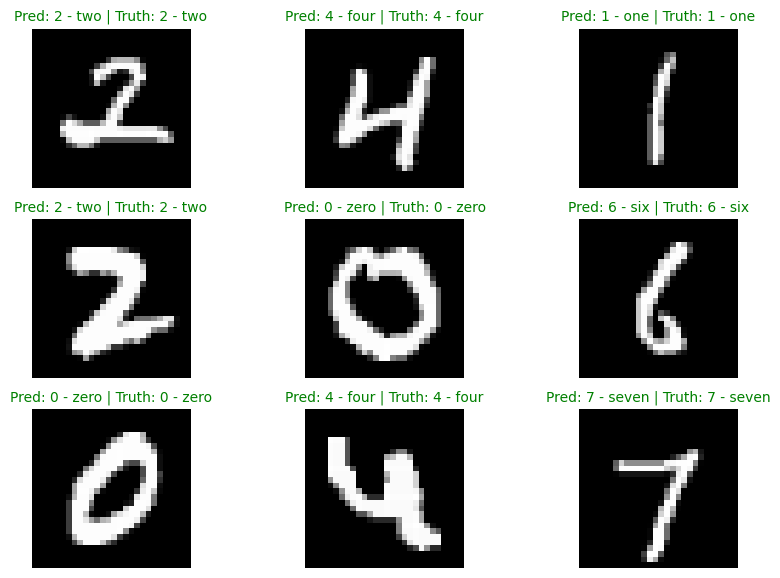

In [18]:
plt.figure(figsize=(10, 7))

rows, cols = 3, 3

for i, sample in enumerate(test_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sample.squeeze(dim=0), cmap="gray")

    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if prediction is correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if prediction is incorrect

    plt.axis(False)

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [26]:
y_preds = []

model.eval()
with torch.inference_mode():
    for X, y, in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        y_pred = torch.softmax(y_logits.squeeze(), dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
    
y_preds = torch.cat(y_preds)
y_preds

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 277.96it/s]


tensor([7, 2, 1,  ..., 4, 5, 6])

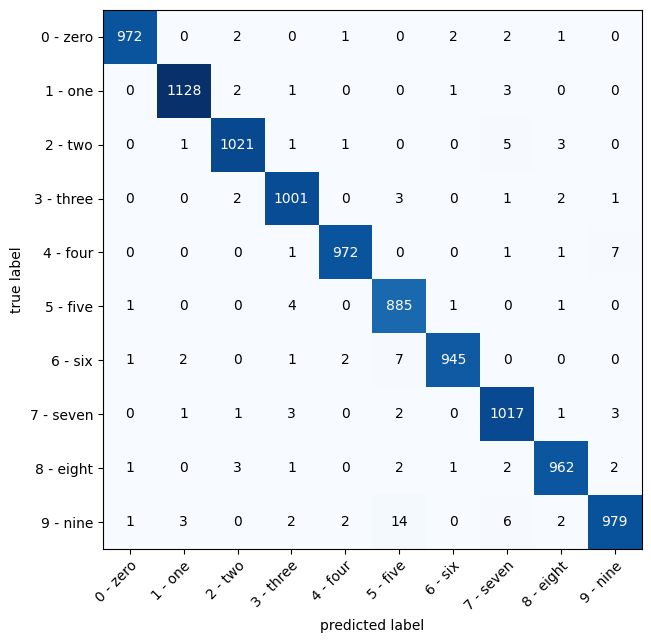

In [110]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

conf_mat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_mat_tensor = conf_mat(y_preds, test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(), class_names=class_names, figsize=(10,7))

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [48]:
random_tensor = torch.randn(size=(1, 3, 24, 24))

conv2d = nn.Conv2d(in_channels=3,
                    out_channels=5,
                    kernel_size=4)

random_tensor_logit = conv2d(random_tensor)
random_tensor_logit.shape

# Answer: Each increase of the kernel size will decrease the shape of the output

torch.Size([1, 5, 21, 21])

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [112]:
from torchvision.datasets import FashionMNIST

fashion_train_data = FashionMNIST(root="data",
                                  train=True,
                                  download=False,
                                  target_transform=None,
                                  transform=ToTensor())

fashion_test_data = FashionMNIST(root="data",
                                 train=False,
                                 download=False,
                                 target_transform=None,
                                 transform=ToTensor())

fashion_test_dataloader = DataLoader(fashion_test_data,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)

fashion_class_names = fashion_train_data.classes

In [113]:
class FashionMNISTModel(nn.Module):
    """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website
    """
    def __init__(self, in_shape: int, hidden_units: int, out_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3, 
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, 
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,  # there's a trick to calculating this
                      out_features=out_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1 {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2 {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape of conv_block_2 {x.shape}")
        
        return(x)

In [114]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
FULL_PATH = MODEL_PATH / MODEL_NAME

model_2 = FashionMNISTModel(in_shape=1,
                            hidden_units=10,
                            out_shape=len(fashion_test_data.classes)).to(device)

model_2.load_state_dict(torch.load(f=FULL_PATH))

<All keys matched successfully>

In [102]:
preds = []

for X, y in tqdm(fashion_test_dataloader):
    X, y = X.to(device), y.to(device)
    logit = model_2(X)
    pred = torch.softmax(logit.squeeze(), dim=1).argmax(dim=1)
    preds.append(pred)

preds = torch.cat(preds)
preds

100%|██████████| 313/313 [00:01<00:00, 268.81it/s]


tensor([9, 2, 1,  ..., 8, 1, 5])

In [111]:
# Get wrong prediction indexes
import numpy as np
wrong_pred_indexes = np.where(preds != fashion_test_data.targets)[0]
len(wrong_pred_indexes)

1201

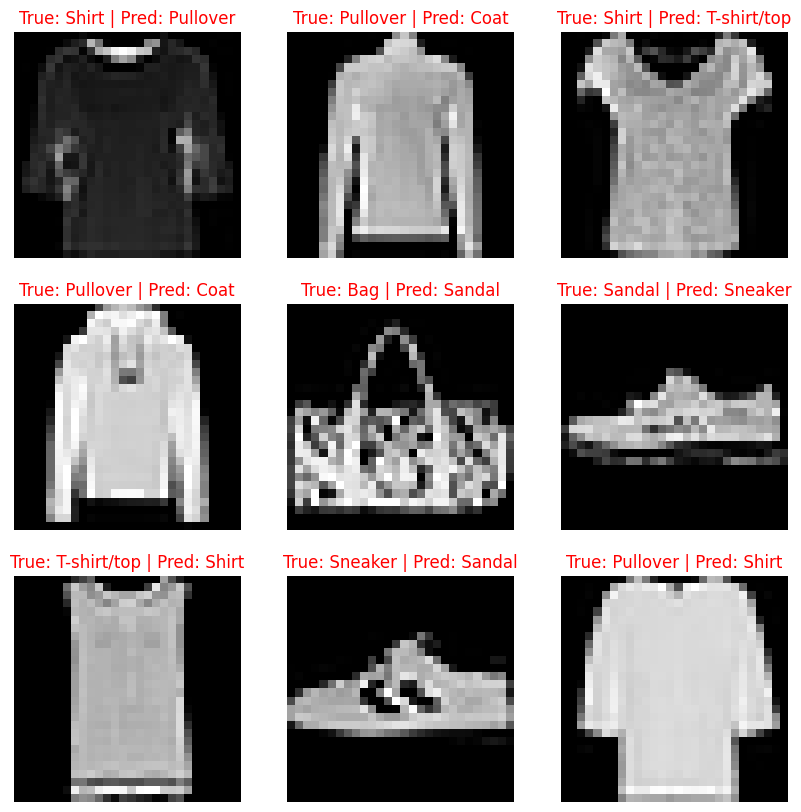

In [ ]:
import random
random_selection = random.sample(list(wrong_pred_indexes), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  # Get true and pred labels
  true_label = fashion_class_names[fashion_test_data[idx][1]]
  pred_label = fashion_class_names[preds[idx]]

  # Plot the wrong prediction with its original label
  plt.subplot(3, 3, i+1)
  plt.imshow(fashion_test_data[idx][0].squeeze(), cmap="gray")
  plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
  plt.axis(False)

Answer: I think it is a data error, as these data are visually similar that even a human can get these wrong